In [33]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class FeedbackHHC:
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)

    def iqr_outliers(self, col):
        Q1 = self.data[col].quantile(0.25)
        Q3 = self.data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_threshold = Q1 - 7 * IQR
        upper_threshold = Q3 + 7 * IQR
        self.data[col] = np.where(
                    (self.data[col] < lower_threshold) | (self.data[col] > upper_threshold),
                    np.nan,
                    self.data[col]
                )
        
    def preprocess_data(self):

        # delete duplicates & irrelevant data
        self.data.drop_duplicates(inplace=True)
        self.data.drop(['Certification Date','Footnote for how often patients got better at taking their drugs correctly by mouth','Footnote for how often patients got better at walking or moving around','Footnote for how often the home health team determined whether patients received a flu shot for the current flu season','Footnote for how much Medicare spends on an episode of care at this agency, compared to '
                        'Medicare spending across all agencies nationally', 'Footnote for PPR Risk-Standardized Rate',
                        'Footnote for DTC Risk-Standardized Rate', 'Footnote for Application of Percent of Long Term '
                                                                   'Care Hospital Patients with an Admission and '
                                                                   'Discharge Functional Assessment and a Care Plan '
                                                                   'that Addresses Function', 'Footnote for Percent of '
                                                                                              'Residents Experiencing '
                                                                                              'One or More Falls with '
                                                                                              'Major Injury',
                        'Footnote for how often physician-recommended actions to address medication issues were '
                        'completely timely', 'Footnote Changes in skin integrity post-acute care: pressure '
                                             'ulcer/injury', 'Footnote for how often patients receiving home health '
                                                             'care needed urgent, unplanned care in the ER without '
                                                             'being admitted', 'Footnote for how often home health '
                                                                               'patients had to be admitted to the '
                                                                               'hospital', 'Footnote for how often '
                                                                                           'patients got better at '
                                                                                           'taking'
                                                                                           'their drugs correctly by '
                                                                                           'mouth', 'Footnote for how '
                                                                                                    'often patients\' '
                                                                                                    'breathing improved',
                        'Footnote for how often patients got better at bathing', 'Footnote for how often patients got '
                                                                                 'better at getting in and out of '
                                                                                 'bed', 'Footnote for how often '
                                                                                        'patients got better at walking'
                                                                                        'or moving around',
                        'Footnote for how'
                        'often the home '
                        'health team '
                        'determined whether '
                        'patients received a '
                        'flu shot for the '
                        'current flu '
                        'season',
                        'Footnote for how often the home health team began their patients\' care in a timely manner',
                        'Footnote for PPH Risk-Standardized Rate', 'Footnote for quality of patient care star rating',
                        'Provider ID', 'Provider Name', 'Hospital Name', 'Address', 'City/Town', 'State', 'ZIP Code',
                        'County Name', 'Telephone Number', 'Hospital Type', 'Type of Ownership', 'Emergency '
                                                                                                 'Services',
                        'Meets criteria for meaningful use of EHRs', 'Hospital overall rating', 'Mortality national '
                                                                                                'comparison',
                        'Safety of care national comparison', 'Readmission national comparison', 'Patient experience '
                                                                                                 'national '
                                                                                                 'comparison',
                        'Effectiveness of care national comparison', 'Timeliness of care national comparison',
                        'Efficient use of medical imaging national comparison', 'CMS Certification Number (CCN)'],
                       axis=1, inplace=True, errors='ignore')
        
        # delete rows with value '-' instead of 'Yes' or 'No'
        yes_no_columns = [
            'Offers Nursing Care Services',
            'Offers Physical Therapy Services',
            'Offers Occupational Therapy Services',
            'Offers Speech Pathology Services',
            'Offers Medical Social Services',
            'Offers Home Health Aide Services'
        ]
        for col in yes_no_columns:
            self.data[col].replace('-', np.nan, inplace=True)
        self.data.dropna(subset=yes_no_columns, how='any', inplace=True)

        # replace 'Yes' in columns with 1 and 'No' with 0
        self.data.replace('Yes', 1, inplace=True)
        self.data.replace('No', 0, inplace=True)

        other_columns = ['DTC Performance Categorization', 'PPH Performance Categorization',
                    'PPR Performance Categorization']
        
        # inlocuim valorile numerice lipsa cu media
        for col in self.data.columns:
            try:
                if col not in other_columns and col not in yes_no_columns:
                    self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
                    self.data[col].fillna(self.data[col].mean(), inplace=True)
            except ValueError:
                pass

        # replace strings with numerical values
        self.data.replace('Not Available', 0, inplace=True)
        self.data.replace('-', np.nan, inplace=True)
        self.data.replace('Same As National Rate', 0, inplace=True)
        self.data.replace('Better Than National Rate', 1, inplace=True)
        self.data.replace('Worse Than National Rate', -1, inplace=True)

        # remove outliers
        for col in self.data.columns:
            if col not in other_columns and col not in yes_no_columns:
                self.iqr_outliers(col)
        
        # drop rows containing NaN (outliers)
        self.data.dropna(inplace=True)

    def exploratory_analysis(self):
        numeric_columns = self.data.select_dtypes(include=np.number).columns
        numeric_data = self.data[numeric_columns]

        print("The average for the attributes:\n", numeric_data.mean())
        print("\nThe median for the attributes:\n", numeric_data.median())

        for col in numeric_columns:
            plt.figure(figsize=(6, 4)) 
            numeric_data[col].hist(bins=20, color='lightpink', edgecolor='black')
            plt.title(col)
            plt.show()

    def select_attributes_pca(self):
        numeric_columns = self.data.select_dtypes(include=np.number).columns
        numeric_data = self.data[numeric_columns]

        pca=PCA()
        pca.fit(numeric_data)
        
        # calculam variația cumulativă și determinam numarul de componente
        variatie_cumulativa = np.cumsum(pca.explained_variance_ratio_)
        numar_componente = np.where(variatie_cumulativa > 0.95)[0][0] + 1

        # aplicam PCA cu numarul optim de componente
        pca_optim = PCA(n_components=numar_componente)
        pca_optim.fit(numeric_data)

        # afisam atributele selectate
        print("Selected attributes are:")
        print("--------------------------------------------------------------------------------------------------------------------------------------------\n")
        for i in range(numar_componente):
            print(f"Main component #{i + 1}:")
            component = pca_optim.components_[i]
            importance = pd.Series(component, index=numeric_columns)
            display(importance.sort_values(ascending=False))
    

        # vizualizarea atributelor selectate
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='lightpink')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Variation of Explained Variance')
        plt.grid()
        plt.show()

Principal Component Analysis (PCA) is a statistical method used for dimensionality reduction in datasets with multiple correlated variables. 
It transforms these variables into a set of uncorrelated components, capturing the maximum variance in the data. 
PCA works by computing new variables (principal components) that are linear combinations of the original ones, ordered by the variance they explain. 
These components are orthogonal, ensuring unique information capture. It's employed for dimensionality reduction, simplifying complex data while retaining essential patterns. 
PCA involves a trade-off between dimensionality reduction and information loss, making it important to balance data compression with retaining meaningful insights.

,State,CMS Certification Number (CCN),Provider Name,Address,City/Town,ZIP Code,Telephone Number,Type of Ownership,Offers Nursing Care Services,Offers Physical Therapy Services,...,PPH Denominator,PPH Observed Rate,PPH Risk-Standardized Rate,PPH Risk-Standardized Rate (Lower Limit),PPH Risk-Standardized Rate (Upper Limit),PPH Performance Categorization,Footnote for PPH Risk-Standardized Rate,"How much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally","Footnote for how much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally","No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)"
0,AK,27001,PROVIDENCE HOME HEALTH ALASKA,"4001 DALE STREET, SUITE 101",ANCHORAGE,99508,9075630130,VOLUNTARY NON PROFIT - RELIGIOUS AFFILIATION,Yes,Yes,...,395,11.14,10.13,7.91,13.02,Same As National Rate,-,0.89,-,"1,057"
1,AK,27002,HOSPICE & HOME CARE OF JUNEAU,1803 GLACIER HIGHWAY,JUNEAU,99801,9074633113,VOLUNTARY NON PROFIT - RELIGIOUS AFFILIATION,Yes,Yes,...,73,4.11,7.12,4.26,11.48,Same As National Rate,-,0.86,-,346
2,AK,27006,FAIRBANKS MEMORIAL HOSPITAL HHA,1701 GILLAM WAY,FAIRBANKS,99701,9074585410,VOLUNTARY NON-PROFIT - OTHER,Yes,Yes,...,156,5.77,7.97,5.08,12.17,Same As National Rate,-,0.79,-,464
3,AK,27008,ANCORA HOME HEALTH & HOSPICE,3831 E BLUE LUPINE DRIVE,WASILLA,99654,9073524800,PROPRIETARY,Yes,Yes,...,855,8.54,8.60,6.99,10.49,Same As National Rate,-,0.90,-,"2,011"
4,AK,27009,PETERSBURG MEDICAL CENTER HOME,P.O. BOX 589,PETERSBURG,99833,9077724291,GOVERNMENT - STATE/COUNTY,Yes,Yes,...,50,8.00,10.05,6.20,16.67,Same As National Rate,-,1.04,-,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11734,WY,537831,BEST HOME HEALTH & HOSPICE LLC,105 YELLOW CREEK ROAD,EVANSTON,82930,3077892899,PROPRIETARY,Yes,Yes,...,210,11.43,13.02,9.18,17.56,Same As National Rate,-,0.93,-,"1,233"
11735,WY,537833,PREMIUM HEALTH AT HOME INC,1262 N 22ND ST,LARAMIE,82072,3077458710,PROPRIETARY,Yes,Yes,...,14,-,-,-,-,Not Available,The number of patient episodes for this measur...,0.80,-,54
11736,WY,537834,PREMIUM HEALTH AT HOME RAWLINS LLC,"405 W CEDAR ST., SUITE B",RAWLINS,82301,3073285999,PROPRIETARY,Yes,Yes,...,6,-,-,-,-,Not Available,The number of patient episodes for this measur...,1.03,-,33
11737,WY,537835,ECLIPSE HOME HEALTH,"304 COFFEEN AVENUE, SUITE B",SHERIDAN,82801,3072780424,-,-,-,...,18,-,-,-,-,Not Available,The number of patient episodes for this measur...,1.04,-,25


,Offers Nursing Care Services,Offers Physical Therapy Services,Offers Occupational Therapy Services,Offers Speech Pathology Services,Offers Medical Social Services,Offers Home Health Aide Services,Quality of patient care star rating,How often the home health team began their patients' care in a timely manner,How often the home health team determined whether patients received a flu shot for the current flu season,How often patients got better at walking or moving around,...,PPR Performance Categorization,PPH Numerator,PPH Denominator,PPH Observed Rate,PPH Risk-Standardized Rate,PPH Risk-Standardized Rate (Lower Limit),PPH Risk-Standardized Rate (Upper Limit),PPH Performance Categorization,"How much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally","No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)"
0,1,1,1,1,1,1,4.500000,96.700000,42.200000,86.700000,...,0.0,44.000000,395.0,11.140000,10.130000,7.910000,13.020000,0.0,0.89,317.651972
1,1,1,1,1,1,1,2.000000,91.900000,56.100000,59.400000,...,0.0,3.000000,73.0,4.110000,7.120000,4.260000,11.480000,0.0,0.86,346.000000
2,1,1,0,0,1,1,2.500000,60.900000,55.100000,71.900000,...,0.0,9.000000,156.0,5.770000,7.970000,5.080000,12.170000,0.0,0.79,464.000000
3,1,1,1,1,1,1,3.500000,98.100000,52.200000,84.700000,...,0.0,73.000000,855.0,8.540000,8.600000,6.990000,10.490000,0.0,0.90,317.651972
5,1,1,1,1,1,1,2.000000,96.500000,44.600000,72.300000,...,0.0,10.000000,107.0,9.350000,9.550000,5.940000,14.640000,0.0,1.14,294.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11728,1,1,1,1,1,1,3.000000,95.100000,76.100000,68.100000,...,0.0,5.000000,101.0,4.950000,7.070000,4.230000,11.320000,0.0,0.98,230.000000
11729,1,1,1,1,1,1,5.000000,98.800000,58.100000,97.300000,...,0.0,24.000000,222.0,10.810000,10.490000,7.600000,13.860000,0.0,1.10,493.000000
11732,1,1,1,1,1,1,4.000000,100.000000,61.500000,85.700000,...,0.0,21.000000,231.0,9.090000,10.090000,7.080000,14.290000,0.0,0.92,741.000000
11733,1,1,1,1,0,1,2.000000,95.100000,56.700000,42.700000,...,0.0,6.000000,80.0,7.500000,10.240000,5.910000,16.200000,0.0,1.01,327.000000


The average for the attributes:
 Offers Nursing Care Services                                                                                                                                  0.998886
Offers Physical Therapy Services                                                                                                                              0.995357
Offers Occupational Therapy Services                                                                                                                          0.964896
Offers Speech Pathology Services                                                                                                                              0.915676
Offers Medical Social Services                                                                                                                                0.872585
Offers Home Health Aide Services                                                                                                    

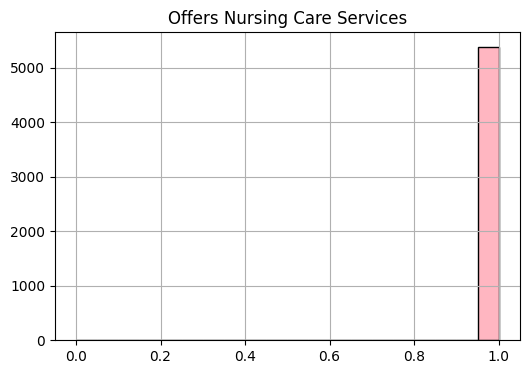

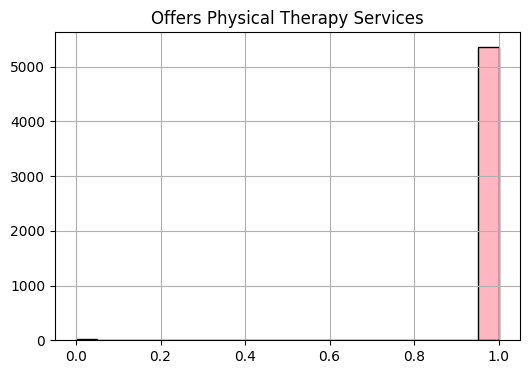

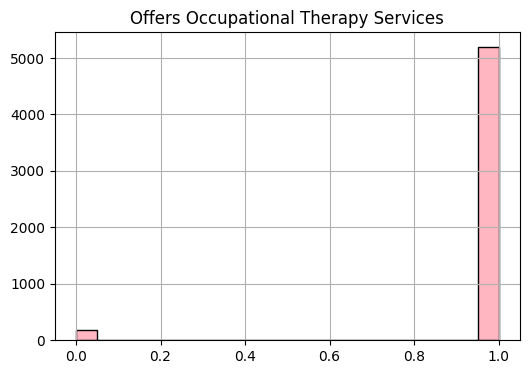

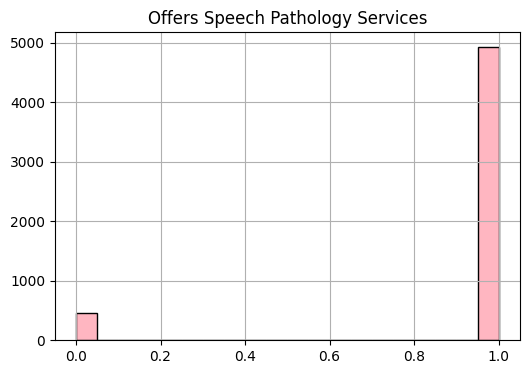

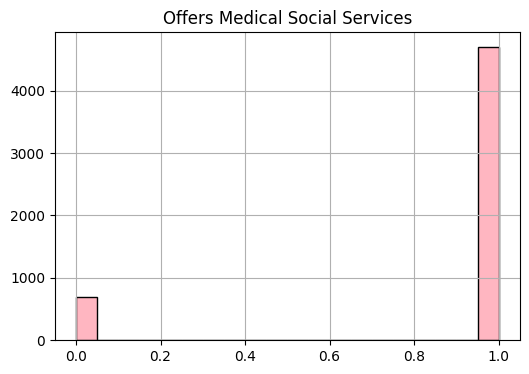

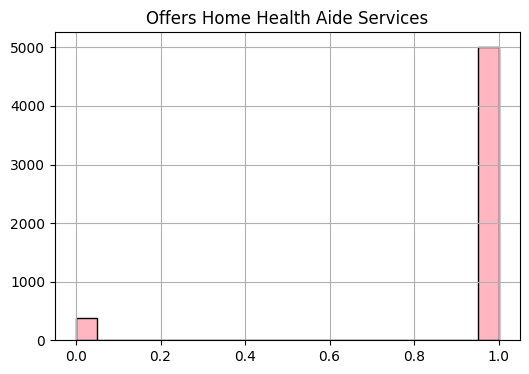

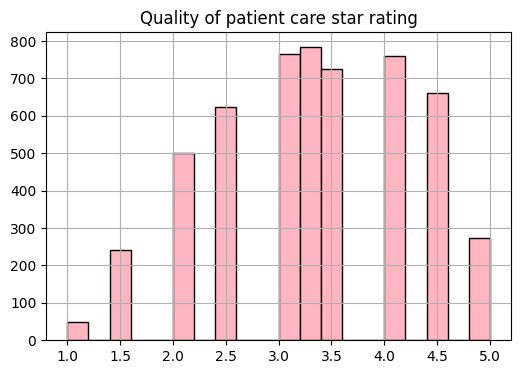

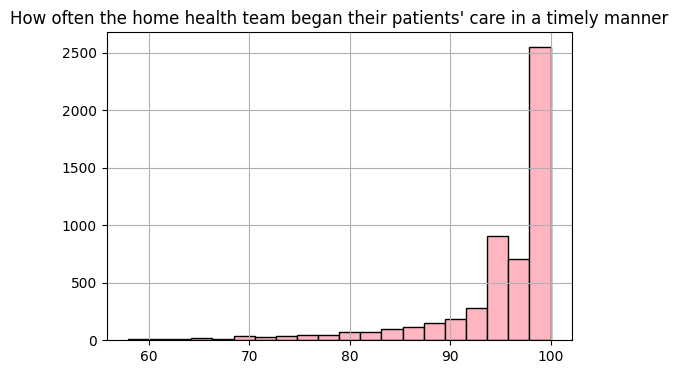

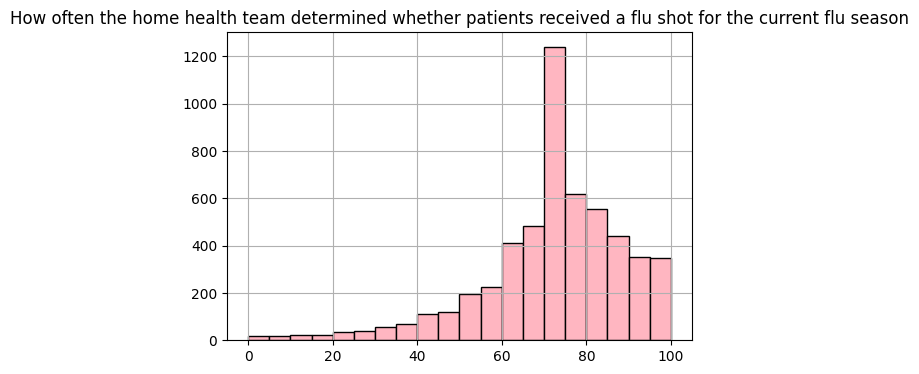

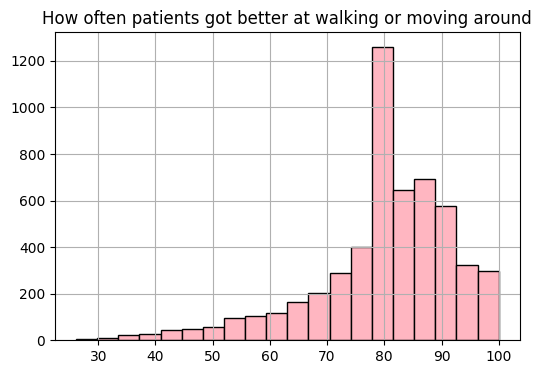

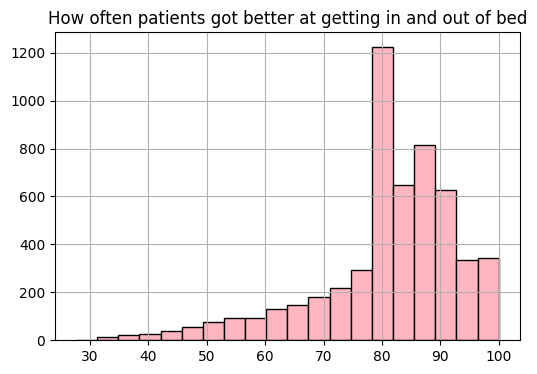

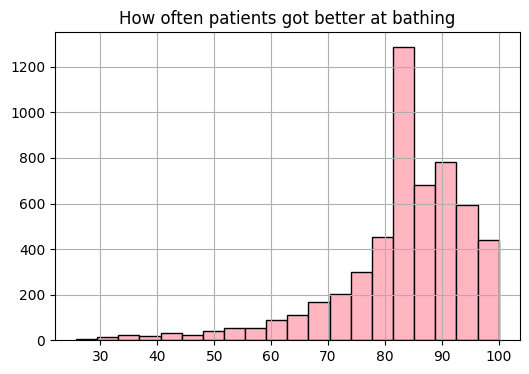

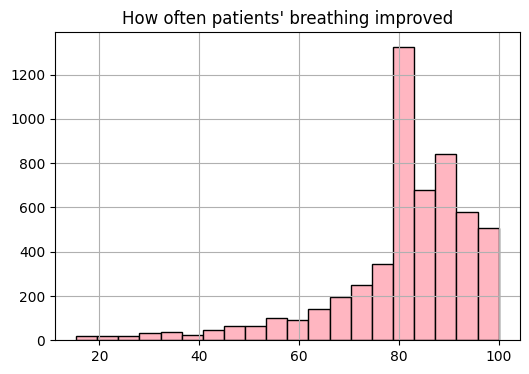

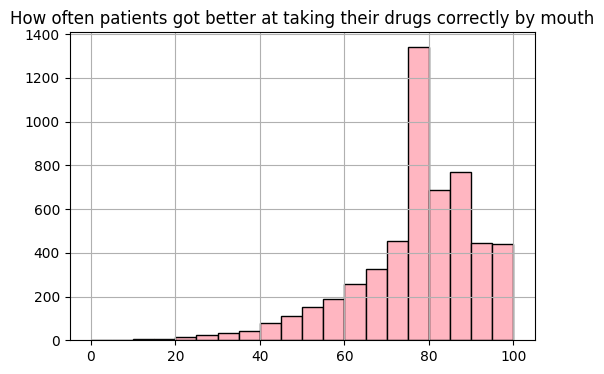

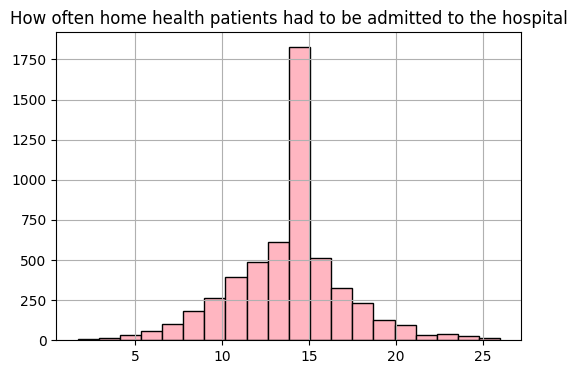

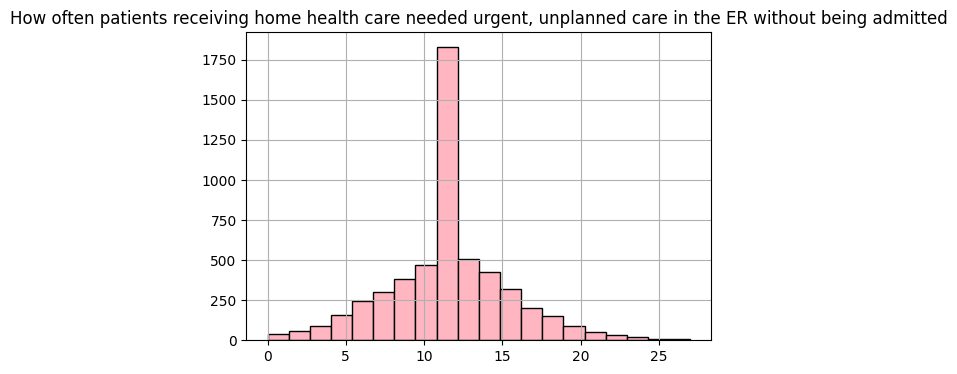

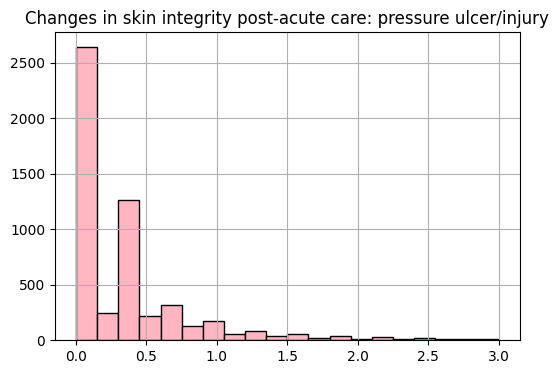

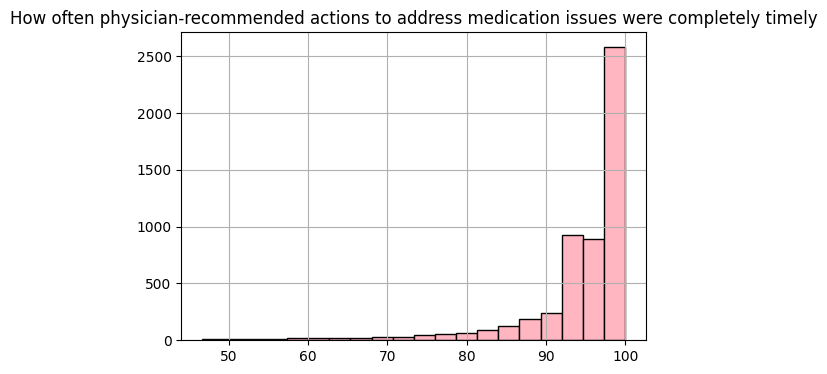

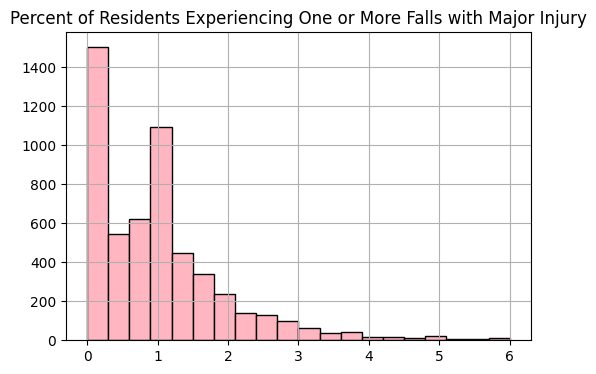

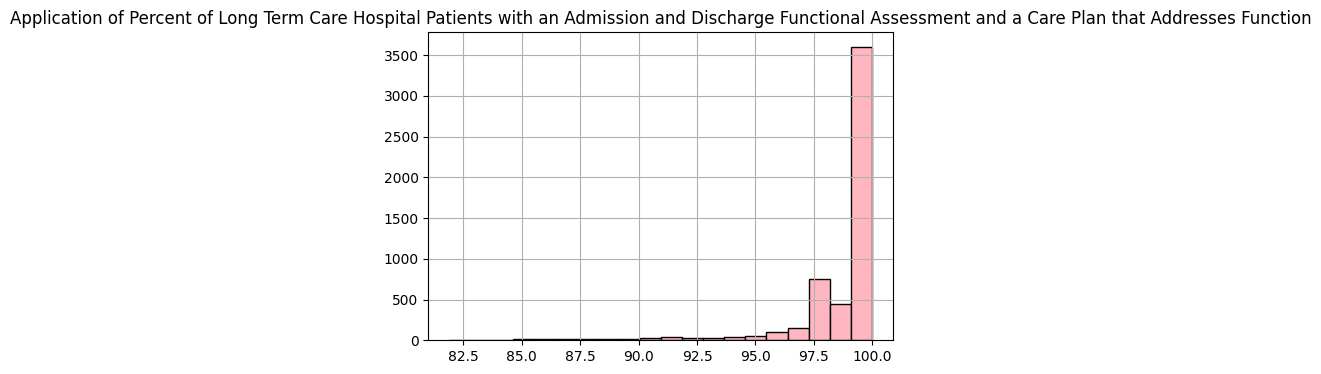

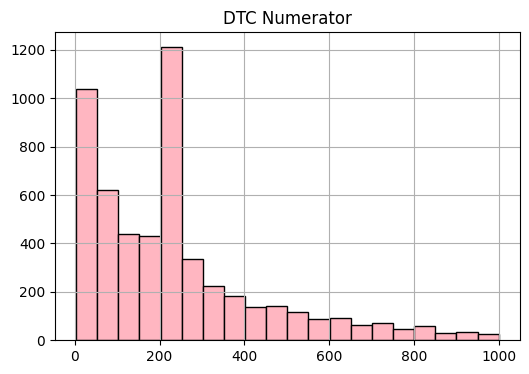

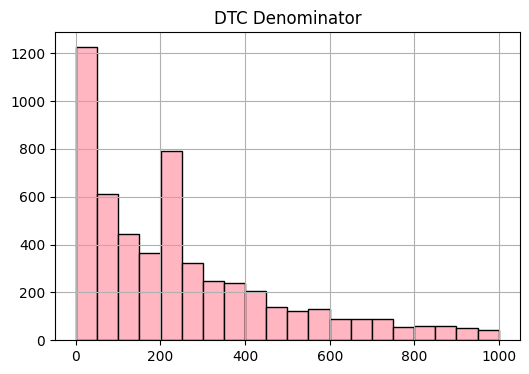

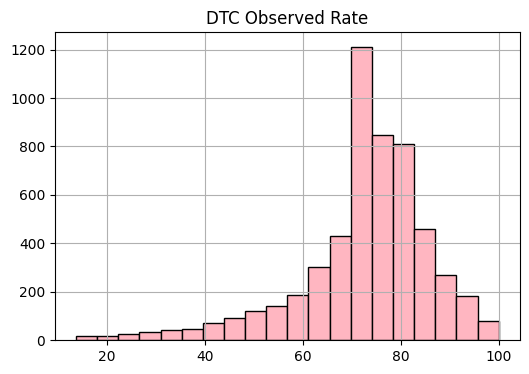

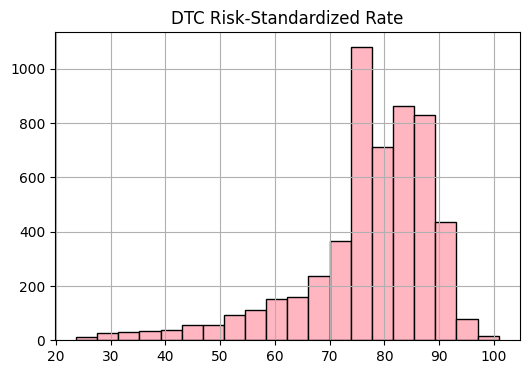

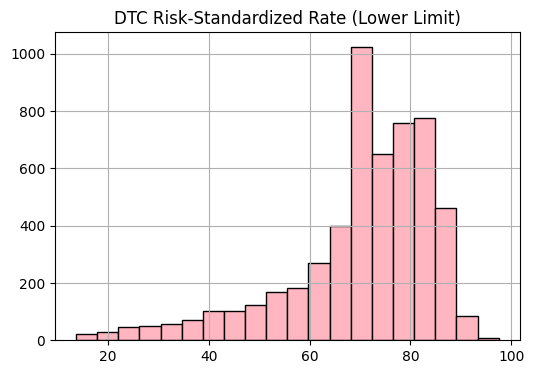

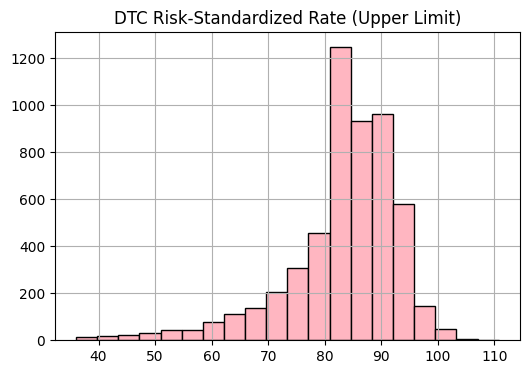

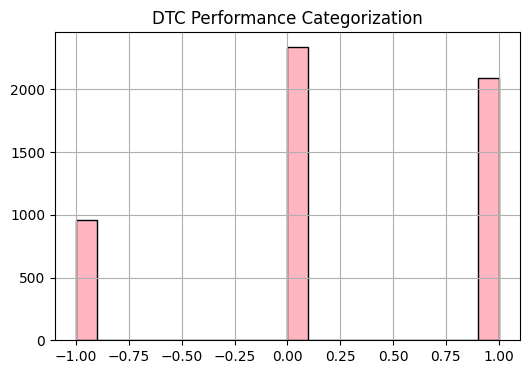

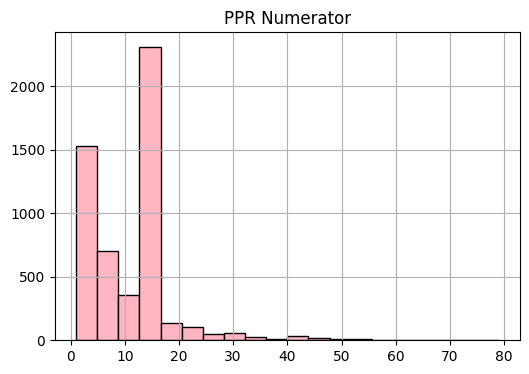

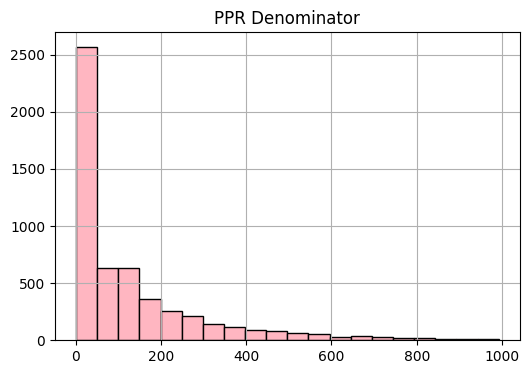

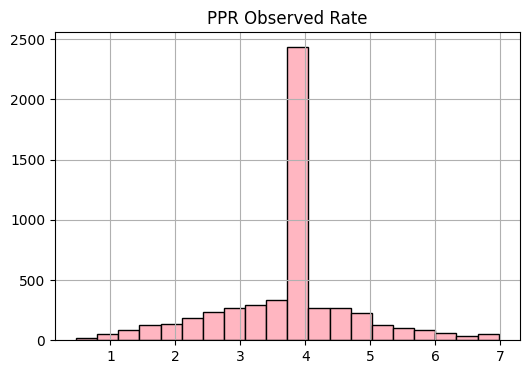

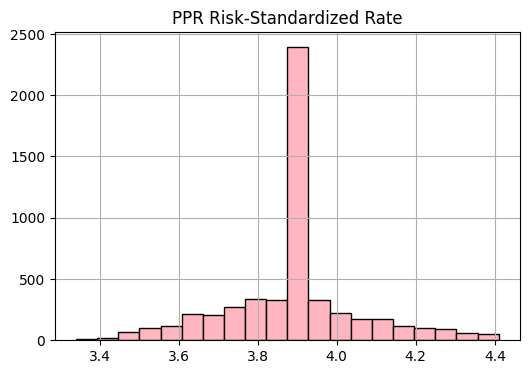

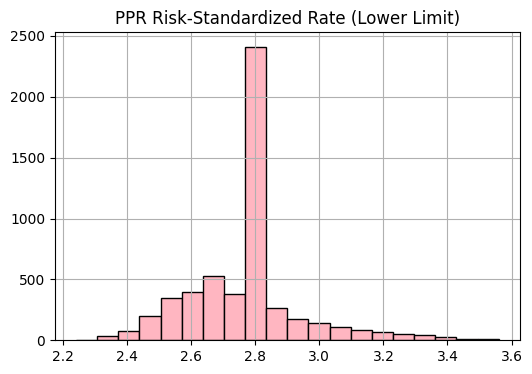

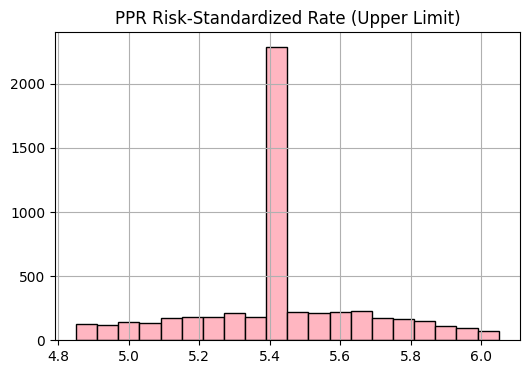

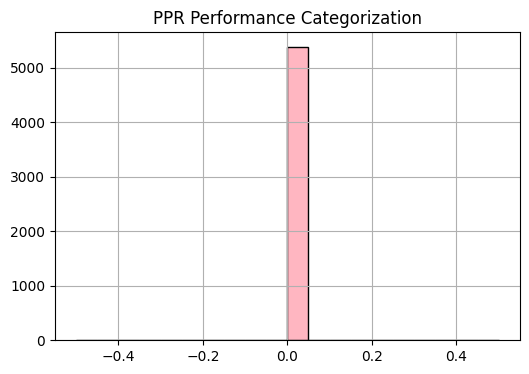

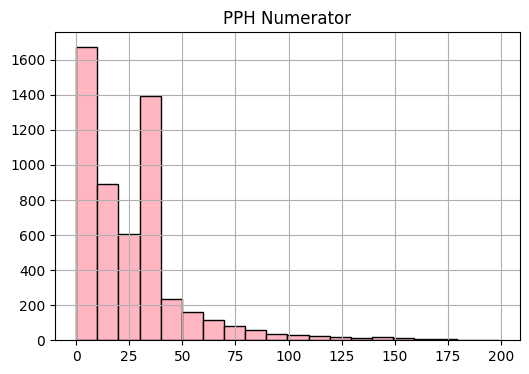

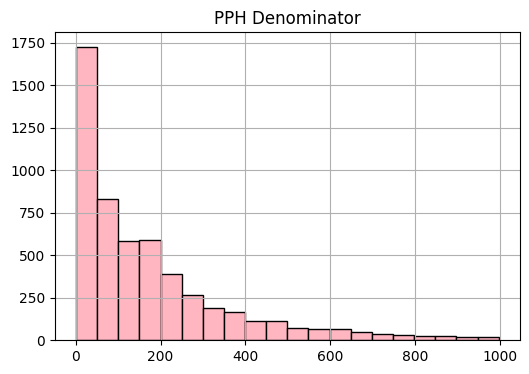

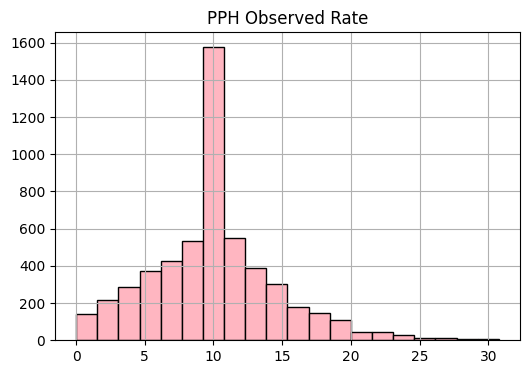

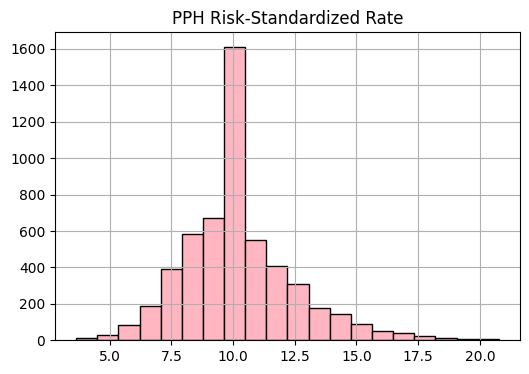

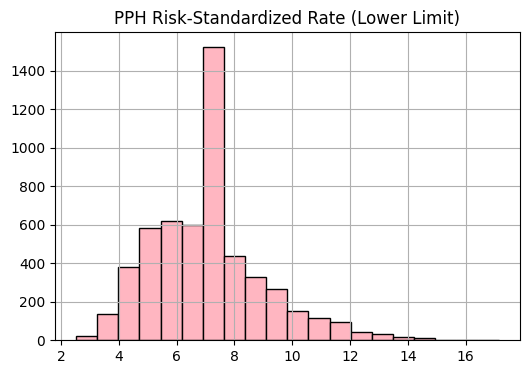

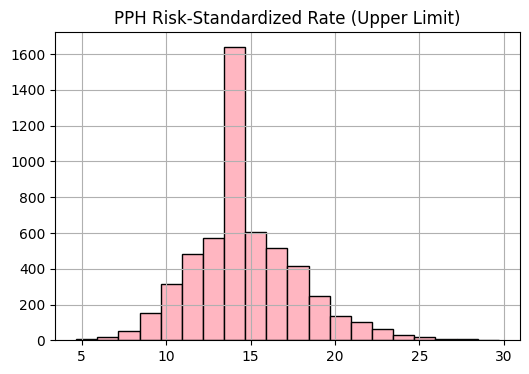

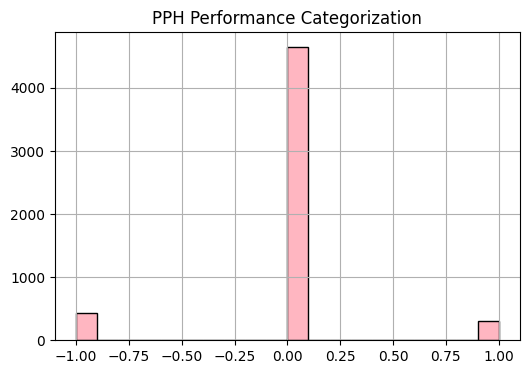

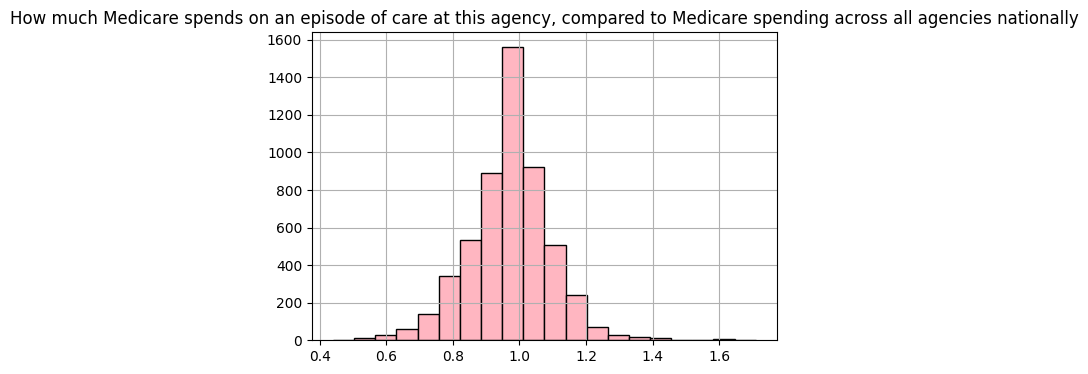

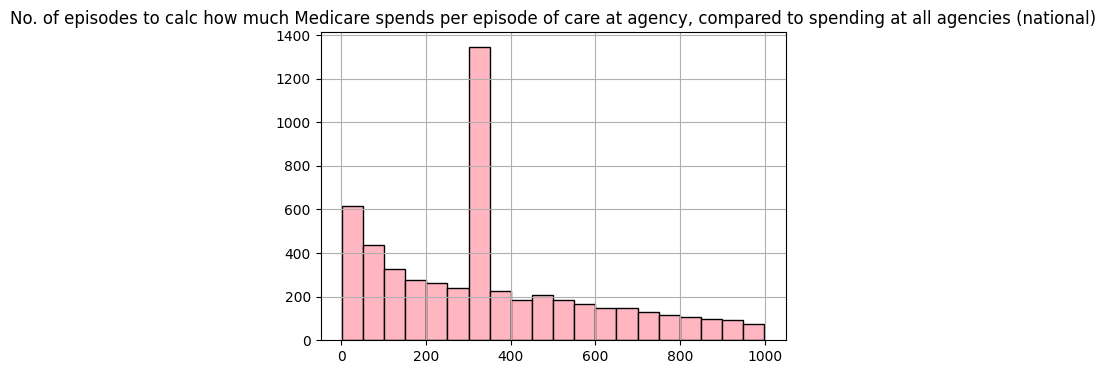

Selected attributes are:
--------------------------------------------------------------------------------------------------------------------------------------------

Main component #1:


DTC Denominator                                                                                                                                             5.469915e-01
DTC Numerator                                                                                                                                               4.605376e-01
No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)                             4.339308e-01
PPH Denominator                                                                                                                                             4.183971e-01
PPR Denominator                                                                                                                                             3.514632e-01
PPH Numerator                                                                                                                                              

Main component #2:


No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)                             8.311357e-01
DTC Denominator                                                                                                                                             5.760911e-02
PPH Risk-Standardized Rate (Upper Limit)                                                                                                                    3.377568e-03
PPH Observed Rate                                                                                                                                           2.181086e-03
PPH Risk-Standardized Rate                                                                                                                                  1.138580e-03
How often the home health team began their patients' care in a timely manner                                                                               

Main component #3:


PPR Denominator                                                                                                                                             0.487799
PPH Denominator                                                                                                                                             0.440400
No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)                             0.289087
PPH Numerator                                                                                                                                               0.049486
PPR Numerator                                                                                                                                               0.019085
How often patients got better at taking their drugs correctly by mouth                                                                                      0.004462
PPH Observ

Main component #4:


DTC Numerator                                                                                                                                               0.768051
No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)                             0.191256
DTC Risk-Standardized Rate (Lower Limit)                                                                                                                    0.019847
DTC Observed Rate                                                                                                                                           0.016484
DTC Risk-Standardized Rate                                                                                                                                  0.013428
DTC Risk-Standardized Rate (Upper Limit)                                                                                                                    0.008012
How often 

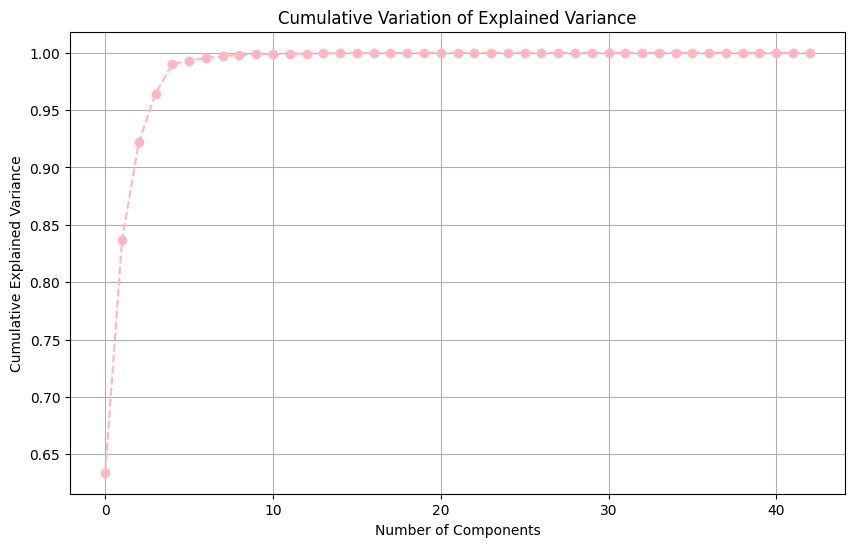

In [34]:
def main():
    data = FeedbackHHC(r'HH_Provider_Oct2023.csv')
    display(data.data)

    data.preprocess_data()
    display(data.data)
    # data.data.to_csv('HH_Provider_Oct2023_preprocessed.csv', index=False)
    
    data.exploratory_analysis()
    data.select_attributes_pca()


if __name__ == "__main__":
    main()